In [1]:
from google.colab import drive
import os

# mount my Google Drive to the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the path to my data file
file_path = '/content/drive/My Drive/AI-Search-Optimization-TSP/data/cities.csv'

# ensure file exists
if os.path.exists(file_path):
    print("SUCCESS: File found!")
else:
    print("ERROR: File not found. Check your folder names.")

SUCCESS: File found!


In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

file_path = '/content/drive/My Drive/AI-Search-Optimization-TSP/data/cities.csv'
df = pd.read_csv(file_path)

print("Number of cities:", len(df))
print("\nFirst 5 rows of data:")
display(df.head())

Number of cities: 50

First 5 rows of data:


,City,X,Y
0,City_1,37.454012,95.071431
1,City_2,73.199394,59.865848
2,City_3,15.601864,15.599452
3,City_4,5.808361,86.617615
4,City_5,60.111501,70.807258


In [6]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# FIX: Clean column names first
# This removes spaces and converts to lowercase (e.g., " X " becomes "x")
df.columns = df.columns.str.strip().str.lower()

# FIX: Robust Column Selection
# If 'x' and 'y' exist after cleaning, use them.
# Otherwise, just take the 2nd and 3rd columns automatically.
if 'x' in df.columns and 'y' in df.columns:
    cities = df[['x', 'y']].values
else:
    # Fallback: Select the 2nd and 3rd columns by index (0=Name, 1=X, 2=Y)
    print("Column names 'x'/'y' not found. Using columns 2 and 3 automatically.")
    cities = df.iloc[:, 1:3].values

num_cities = len(cities)
print(f"Successfully loaded {num_cities} cities.")

# DISTANCE FUNCTION
def calculate_total_distance(route):
    """Calculates total distance of a route (visiting all cities and returning to start)."""
    total_dist = 0
    for i in range(len(route)):
        from_city = route[i]
        to_city = route[(i + 1) % len(route)]  # Wrap around to the start
        # Euclidean distance formula: sqrt((x2-x1)^2 + (y2-y1)^2)
        dist = np.sqrt(np.sum((cities[from_city] - cities[to_city])**2))
        total_dist += dist
    return total_dist

# HELPER FUNCTIONS
def generate_random_route():
    return list(np.random.permutation(num_cities))

print("Setup complete. Distance function ready.")

Successfully loaded 50 cities.
Setup complete. Distance function ready.


In [7]:
import math
import random
import numpy as np

# SIMULATED ANNEALING ALGORITHM
def simulated_annealing(max_iterations=10000, temp=1000, cooling_rate=0.995):
    # 1. Start with a random solution
    current_route = generate_random_route()
    current_dist = calculate_total_distance(current_route)

    best_route = list(current_route)
    best_dist = current_dist

    dist_history = []

    # 2. Iterate
    for i in range(max_iterations):
        # Create a neighbor by swapping two cities
        new_route = list(current_route)
        idx1, idx2 = random.sample(range(num_cities), 2)
        new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]

        new_dist = calculate_total_distance(new_route)

        # 3. Acceptance Probability
        if new_dist < current_dist:
            accept = True
        else:
            # If worse, accept with probability based on temperature
            prob = math.exp((current_dist - new_dist) / temp)
            accept = random.random() < prob

        if accept:
            current_route = new_route
            current_dist = new_dist

        # Keep track of best ever found
        if current_dist < best_dist:
            best_dist = current_dist
            best_route = list(current_route)

        dist_history.append(best_dist)
        temp *= cooling_rate # Cool down

    return best_route, best_dist, dist_history

# Run the algorithm
print("Running Simulated Annealing...")
sa_route, sa_dist, sa_history = simulated_annealing()
print(f"Simulated Annealing Best Distance: {sa_dist:.2f}")

# Save sequence to file (Requirement)
np.savetxt("sa_solution.txt", sa_route, fmt='%d')
print("Saved my solution to sa_solution.txt")

Running Simulated Annealing...
Simulated Annealing Best Distance: 837.50
Saved my solution to sa_solution.txt


In [8]:
# GENETIC ALGORITHM
def genetic_algorithm(pop_size=100, generations=500, mutation_rate=0.01):
    # 1. Create Initial Population
    population = [generate_random_route() for _ in range(pop_size)]

    ga_history = []

    for gen in range(generations):
        # Evaluate Fitness (Distance)
        # I am sorting them so the shortest distance is first
        scores = [(calculate_total_distance(ind), ind) for ind in population]
        scores.sort()

        best_in_gen = scores[0][0]
        ga_history.append(best_in_gen)

        # Selection: Keep top 20% (Elitism)
        ranked_pop = [ind for dist, ind in scores]
        population = ranked_pop[:int(pop_size*0.2)]

        # Crossover & Mutation to refill population
        while len(population) < pop_size:
            # Pick 2 parents from the top performers
            parent1, parent2 = random.sample(population[:20], 2)

            # Simple Ordered Crossover
            start, end = sorted(random.sample(range(num_cities), 2))
            child = [-1] * num_cities
            child[start:end] = parent1[start:end]

            fill_pos = end
            for city in parent2:
                if city not in child:
                    if fill_pos >= num_cities: fill_pos = 0
                    child[fill_pos] = city
                    fill_pos += 1

            # Mutation (Swap)
            if random.random() < mutation_rate:
                idx1, idx2 = random.sample(range(num_cities), 2)
                child[idx1], child[idx2] = child[idx2], child[idx1]

            population.append(child)

    # Return the best solution found in the final generation
    return scores[0][1], scores[0][0], ga_history

# Run the algorithm
print("Running Genetic Algorithm (this may take a moment)...")
ga_route, ga_dist, ga_history = genetic_algorithm()
print(f"Genetic Algorithm Best Distance: {ga_dist:.2f}")

# Save sequence to file
np.savetxt("ga_solution.txt", ga_route, fmt='%d')
print("Saved my solution to ga_solution.txt")

Running Genetic Algorithm (this may take a moment)...
Genetic Algorithm Best Distance: 807.77
Saved my solution to ga_solution.txt


Graph created and saved as comparison_plot.png


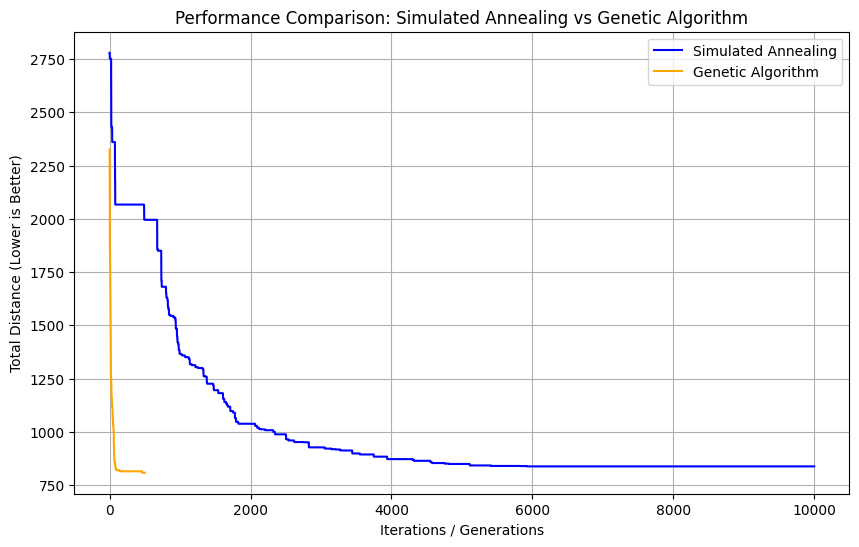

In [9]:
# VISUALIZATION: Convergence Plot
plt.figure(figsize=(10, 6))

# Plot Simulated Annealing History
plt.plot(sa_history, label='Simulated Annealing', color='blue')

# Plot Genetic Algorithm History
plt.plot(ga_history, label='Genetic Algorithm', color='orange')

plt.xlabel('Iterations / Generations')
plt.ylabel('Total Distance (Lower is Better)')
plt.title('Performance Comparison: Simulated Annealing vs Genetic Algorithm')
plt.legend()
plt.grid(True)

# Save the plot to a file so you can put it in your report later
plt.savefig('comparison_plot.png')
print("Graph created and saved as comparison_plot.png")
plt.show()

In [10]:
import time

# Define the problem sizes we need to test
problem_sizes = [10, 20, 30, 40, 50]

print(f"Starting Scalability Test on sizes: {problem_sizes}")
print("-" * 60)
print(f"{'Size':<10} | {'Algorithm':<20} | {'Time (s)':<10} | {'Distance':<10}")
print("-" * 60)

results = {
    'sizes': problem_sizes,
    'sa_times': [],
    'sa_dists': [],
    'ga_times': [],
    'ga_dists': []
}

# Temporary backup of the full 50 cities
full_cities_backup = cities.copy()

for size in problem_sizes:
    # 1. Resize the problem (take the first 'size' cities)
    cities = full_cities_backup[:size]
    num_cities = size

    # 2. Test Simulated Annealing
    start_time = time.time()
    _, sa_dist, _ = simulated_annealing(max_iterations=5000) # Slightly reduced iterations for speed
    sa_duration = time.time() - start_time

    results['sa_times'].append(sa_duration)
    results['sa_dists'].append(sa_dist)
    print(f"{size:<10} | {'Simulated Annealing':<20} | {sa_duration:<10.4f} | {sa_dist:<10.2f}")

    # 3. Test Genetic Algorithm
    start_time = time.time()
    _, ga_dist, _ = genetic_algorithm(generations=200) # Slightly reduced generations for speed
    ga_duration = time.time() - start_time

    results['ga_times'].append(ga_duration)
    results['ga_dists'].append(ga_dist)
    print(f"{size:<10} | {'Genetic Algorithm':<20} | {ga_duration:<10.4f} | {ga_dist:<10.2f}")

# Restore the full dataset
cities = full_cities_backup
num_cities = len(cities)
print("-" * 60)
print("Scalability testing complete.")

Starting Scalability Test on sizes: [10, 20, 30, 40, 50]
------------------------------------------------------------
Size       | Algorithm            | Time (s)   | Distance  
------------------------------------------------------------
10         | Simulated Annealing  | 0.4807     | 290.31    
10         | Genetic Algorithm    | 1.8526     | 290.31    
20         | Simulated Annealing  | 1.1686     | 492.17    
20         | Genetic Algorithm    | 5.5240     | 403.88    
30         | Simulated Annealing  | 1.2793     | 503.50    
30         | Genetic Algorithm    | 5.6109     | 602.40    
40         | Simulated Annealing  | 1.7099     | 821.94    
40         | Genetic Algorithm    | 9.7019     | 576.76    
50         | Simulated Annealing  | 2.0987     | 828.56    
50         | Genetic Algorithm    | 11.7069    | 753.17    
------------------------------------------------------------
Scalability testing complete.
